



The codes are modified from the following source:\
1. https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/3%20-%20Faster%20Sentiment%20Analysis.ipynb \
2.https://github.com/pyg-team/pytorch_geometric/blob/master/examples/node2vec.py \
3.https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=ci-LpZWhRJoI


# Word Embedding
We will use word embedding to predict the sentiment of each sentence in IMDB data. Our plan is to use Keras to pre-process the data, and use Pytorch to build classification model and train the data. 

## Preparing Data
Keras provides us an easy and transparant way to process the data. 

In [ ]:
import numpy as np
import keras
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from keras.datasets import imdb
from torch.utils.data import Dataset, DataLoader
from pprint import pprint

np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

Next, let's load the training and test datasets.

To save training time, let's only keep the 10,000 most frequent words in the corpus. You can increase the number of words to get better performance

In [ ]:
imdb = keras.datasets.imdb
num_words = 10000           # Only the 10,000 most frequent words 

# Load data from keras
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(seed=1, num_words=num_words)

# The first review of the data
print(train_data[0])
print(len(train_data[0]))
print('label:', train_labels[0])

17473536/17464789 [==============================] - 0s 0us/step
[1, 13, 28, 1039, 7, 14, 23, 1856, 13, 104, 36, 4, 699, 8060, 144, 297, 14, 175, 291, 18, 4, 375, 1784, 153, 38, 15, 75, 92, 859, 51, 16, 5, 15, 75, 377, 24, 8, 81, 4, 172, 2497, 174, 40, 1489, 49, 84, 11, 4, 2030, 3039, 121, 36, 92, 4881, 14, 20, 2, 9, 40, 6, 2, 621, 18, 148, 37, 191, 1941, 42, 511, 14, 20, 9, 17, 76, 253, 17, 269, 8, 3336, 4, 2, 8, 1278, 6, 543, 2647, 10, 10, 308, 3102, 2, 47, 43, 188, 46, 7, 1172, 5, 240, 2854, 145, 8, 4, 154, 3243, 11, 4819, 58, 18, 35, 32, 8, 327, 823, 7, 7350, 7, 265, 308, 1828, 145, 1646, 4, 154, 890, 5, 9, 2, 34, 362, 2515, 154, 1914, 5, 27, 2, 2, 17, 36, 837, 5, 1941, 32, 367, 4, 96, 10, 10, 13, 62, 386, 14, 48, 13, 16, 3178, 42, 48, 11, 882, 294, 16, 3412, 2, 4360, 2, 34, 6, 1042, 18, 2, 345, 96, 14, 9, 6, 862, 526, 3757, 917, 5, 60, 1055, 13, 115, 197, 474, 1829, 15, 2006, 7, 6791, 113, 19, 4, 2, 261, 13, 104, 4, 1653, 173, 7, 4, 65, 143, 4, 3801, 1366, 548, 844, 5, 4, 837, 139

For processing raw text from the scratch, there are many tutorials online that you can follow. For example, [here](https://medium.com/geekculture/nlp-with-tensorflow-keras-explanation-and-tutorial-cae3554b1290) or [here](https://realpython.com/python-keras-text-classification/).

We see that the text of each review has been encoded as a sequence of integers. Each word in the text is represented as an integer. A dictionary called the `vocabulary` links each word to a unique integer. In the example above, we see that the integer 13 is repeated many times. This integer corresponds to a very frequent word 'i'. In fact, in the `vocabulary`, the more frequent a word, the lower the integer. 


To get a fixed length input, we can simply truncate the documents to a fixed number of words, say 256. For documents that have more than 256 words, we will keep only the first 256 words. For shorter document, we will fill the unused word slots with zeros. However, you need to study the distribution of document lengths to ensure most  documents are not truncated to maintain the content completeness.


With keras, this is easy to do:

In [ ]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=256)

In [ ]:
# You can check one and notice 0s are appended at the end

train_data[1]

array([   1,  103,  450,  576,   73, 2896,    8,    4,  213,    7,  897,
         13,   16,  576, 3521,   19,    4,   22,    4,   22,   16,  465,
        728,    4, 2563,    4, 1460,    4, 3237,    5,    6,   55,  576,
       1078, 2734,   10,   10,   13,   69, 2721,  873,    8,   67,  111,
        318,  302,    5,   40,    6,    2,    2,   12, 4280,   72,  245,
         19,    4, 4211,    5,    4,    2,    7,   12, 1620,   13,  244,
        174, 2654,  245,   19,  129, 7102,   19,    4,  979,    7,    4,
         65,    5,  129,  459,    7,    4,  318,  302,   25,   80,  140,
          6,  196,   96,   61,  464,   13,   80,  407,   30,    4, 2217,
          7,  129,  337, 1333,   10,   10, 2127,    2,    4,  118,  284,
       1344,   16,    4,  612,   31, 1099,   25,   93, 1792, 7606,  168,
         40,    6,  506, 1079,    8,    2,   10,   10,  444,    4,  116,
         65,  347,    4,  312,  489, 1423,    5, 1190,  302,   12,   16,
        777,   13,   43,  657,   12,   71, 1207,   

In [ ]:
# show mapping between words and index
# dict(sorted(imdb.get_word_index().items(), key=lambda x:x[1]))



In [ ]:
# Decode text

# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print(decoded_review)

1654784/1641221 [==============================] - 0s 0us/step
forget what was and that we remember not to do the same mistakes again like putting some people in the director's chair where they don't belong this movie ? is like a ? musical for those who can't sing or act this movie is as much fun as trying to teach the ? to drive a city bus br br john hood ? has just got out of prison and he's headed back to the old neighborhood in serving time for an all to nice crime of necessity of course john heads back onto the old street and is ? by kids dogs old ladies and his ? ? as they dance and sing all along the way br br i would recommend this if i was sentimental or if in truth someone was smoking ? pot ? by a doctor for ? either way this is a poorly directed scripted acted and even produced i never thought i'd sat that satire of ghetto life with the ? although i think the redeeming part of the story through the wannabe gang fight sequences and the dance numbers his friends care about the

## Train word vectors by Gensim


Check tutorial here: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

## Use Pretrained Wordvector - GloVe
Rather than training our own word vectors from scratch, we will leverage on GloVe. Its authors have released four text files with word vectors trained on different massive web datasets. We will use the smallest file (“ glove.6B.zip”), which was trained on a corpus of 6 billion tokens and contains a vocabulary of 400 thousand tokens. It provides text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. To save training time, We'll use the 50-dimension vectors.  A higher dimension can give you better results.


In [ ]:
# load Glove word vector
import torchtext

vector = torchtext.vocab.GloVe(name='6B', dim=50)

vector["city"]


.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:09<00:00, 43817.03it/s]


tensor([ 0.4394,  0.4327, -0.3665,  0.2778,  0.0629, -0.8020, -0.9304,  0.0164,
        -0.5503, -0.1628, -0.4035, -1.3975,  0.3208, -0.8895, -0.1885,  0.1152,
         0.0453,  0.8300, -0.8759,  0.7765,  0.5595,  0.0747, -0.8467,  0.4098,
        -0.5977, -2.0620, -0.1589,  0.5798,  0.2827, -1.0213,  3.2488,  0.5003,
         0.1156, -1.1707,  0.1902,  0.3689, -0.0420,  0.0282,  0.5412,  0.8489,
        -0.6671,  0.6080,  0.2379, -0.6538, -0.7055,  0.5165, -1.0780, -0.7152,
         0.4840, -0.3256])

## Embedding matrix 


Next we need to look up the Glove vector for each word used in our dataset. 

We limit our vocabulary to 10,000 words. 

Note, the first three words are reserved for padding, unknown tokens, and a symbol to indicate the start of a sentence. We use all zero vectors to represent these words.

In [ ]:
# Look up word vector for each word in our vocabulary

vocab_size = 10000  
emb_dim = 50
missing_words = []  # check if any word without a vector

# initialize embedding matrix
emb_weight = np.zeros((vocab_size, emb_dim))

# loop through all words
for word, idx in word_index.items():

  # align with word index in sentences, since the first 3 indexes are reserved
  if idx + 3 < vocab_size :  
    try:
      emb = vector[word]
      emb_weight[idx+3] = emb    

    # not every word has a vector
    except:
      missing_words.append(word)
    
print(missing_words)

[]


Check embeddings for a few words to ensure our embedding matrix is correct.

In [ ]:
# get index for word city
i = word_index['city']

# remember to add 3 to the index 
print(emb_weight[i+3])

# vector from Glove
vector["city"]

[0.4394 0.4327 -0.3665 0.2778 0.0629 -0.8020 -0.9304 0.0164 -0.5503
 -0.1628 -0.4035 -1.3975 0.3208 -0.8895 -0.1885 0.1152 0.0453 0.8300
 -0.8759 0.7765 0.5595 0.0747 -0.8467 0.4098 -0.5977 -2.0620 -0.1589
 0.5798 0.2827 -1.0213 3.2488 0.5003 0.1156 -1.1707 0.1902 0.3689 -0.0420
 0.0282 0.5412 0.8489 -0.6671 0.6080 0.2379 -0.6538 -0.7055 0.5165 -1.0780
 -0.7152 0.4840 -0.3256]


tensor([ 0.4394,  0.4327, -0.3665,  0.2778,  0.0629, -0.8020, -0.9304,  0.0164,
        -0.5503, -0.1628, -0.4035, -1.3975,  0.3208, -0.8895, -0.1885,  0.1152,
         0.0453,  0.8300, -0.8759,  0.7765,  0.5595,  0.0747, -0.8467,  0.4098,
        -0.5977, -2.0620, -0.1589,  0.5798,  0.2827, -1.0213,  3.2488,  0.5003,
         0.1156, -1.1707,  0.1902,  0.3689, -0.0420,  0.0282,  0.5412,  0.8489,
        -0.6671,  0.6080,  0.2379, -0.6538, -0.7055,  0.5165, -1.0780, -0.7152,
         0.4840, -0.3256])

## Build the Model
The next stage is building the model that we'll eventually train and evaluate. We will build a simple model of 3 layers: the `embedding` layer,  an average laery, and the linear layer:
-  **Embedding layer**: look up for each word in the `emb_matrix` and convert a document to a matrix of shape `(doc_len, emb_dim)`. Here we use pretrained Glove vectors. We freeze `emb_matrix` to make it non-trainable. You can also continue to fine tune the vectors.
- **Average layer**: take the average of word vectors across all words in a document to create a representation for the document.
- **Linear layer**: produce the final prediction.

We now create a neural network with an embedding layer as first layer (we load into it the weights matrix). 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbNN(nn.Module):
    def __init__(self, emb_weight, emb_dim, output_dim):
        
        super().__init__()
        
        # Create a embedding layer using emb_weight.
        # Weights can be frozen or trainable
        self.embedding = nn.Embedding.from_pretrained(emb_weight, freeze=True)
        
        self.fc = nn.Linear(emb_dim, output_dim)
        
    def forward(self, text):
        
        #text shape: [batch size, sent len]
        
        embedded = self.embedding(text)              
        #embedded shape: [batch size, sent len, emb dim]
        
        # Take average of word vectors in a sentence as the feature
        avg = embedded.mean(dim = 1)    
        #avg shape: [batch size, emb_dim]

        output =  self.fc(avg)   
        #output shape: [batch size, output_dim]

        return output

In [ ]:
# create a model
output_dim = 1

emb_dim = 50

# convert emb_matrix to tensor
emb_matrix = torch.Tensor(emb_weight)
print(emb_matrix.shape)

model = EmbNN(emb_matrix,emb_dim, output_dim)

torch.Size([10000, 50])


##Train the Model

As usual, we first define train/test datasets.

In [ ]:
class IMDB_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x).long()
        self.y = torch.Tensor(y).float()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.size()[0]

# dataset
train_dataset = IMDB_dataset(train_data, train_labels)
test_dataset = IMDB_dataset(test_data, test_labels)

In [ ]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# the train function is reused from last lab

def train_model(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1) # (num_batch, 1) -> (num_batch,)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item()
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.3f} train_acc:{train_acc:.3f}, validation loss:{val_loss:.3f} validation acc:{val_acc:.3f}")
    
    return history

In [ ]:
hist = train_model(model, train_dataset, test_dataset, device, \
                   lr=0.0005, epochs = 50, batch_size = 64)

Training Start
Epoch:1 / 50, train loss:0.686 train_acc:0.584, validation loss:0.681 validation acc:0.617
Epoch:2 / 50, train loss:0.675 train_acc:0.636, validation loss:0.672 validation acc:0.641
Epoch:3 / 50, train loss:0.667 train_acc:0.654, validation loss:0.664 validation acc:0.648
Epoch:4 / 50, train loss:0.659 train_acc:0.662, validation loss:0.658 validation acc:0.654
Epoch:5 / 50, train loss:0.653 train_acc:0.667, validation loss:0.652 validation acc:0.661
Epoch:6 / 50, train loss:0.647 train_acc:0.670, validation loss:0.647 validation acc:0.664
Epoch:7 / 50, train loss:0.641 train_acc:0.675, validation loss:0.642 validation acc:0.668
Epoch:8 / 50, train loss:0.636 train_acc:0.676, validation loss:0.637 validation acc:0.672
Epoch:9 / 50, train loss:0.631 train_acc:0.680, validation loss:0.633 validation acc:0.675
Epoch:10 / 50, train loss:0.627 train_acc:0.683, validation loss:0.629 validation acc:0.677
Epoch:11 / 50, train loss:0.623 train_acc:0.685, validation loss:0.626 val

# Node2Vec Embedding Example
We will use the well-known network of Zachary's karate club to illustrate Node2Vec method. This graph describes a social network of 34 members of a karate club and documents links between members. 

In [ ]:
import torch

print(torch.__version__)

1.10.0+cu111


We'll use package `node2vec`. This package is a Python implementation of the node2vec algorithm. Given any graph, it can learn continuous feature representations for the nodes, which can then be used for various downstream machine learning tasks. You can find more details about the package [here](https://github.com/eliorc/node2vec).

In [ ]:
!pip install node2vec 

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=e5cf7d72716eff7658032223e0a9a6b391ce71db0d54acbf320a05464aad388d
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


### Visualize Graph

In [ ]:
import networkx as nx

['Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Officer', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Officer', 'Officer', 'Mr. Hi', 'Mr. Hi', 'Officer', 'Mr. Hi', 'Officer', 'Mr. Hi', 'Officer', 'Officer', 'Officer', 'Officer', 'Officer', 'Officer', 'Officer', 'Officer', 'Officer', 'Officer', 'Officer', 'Officer']


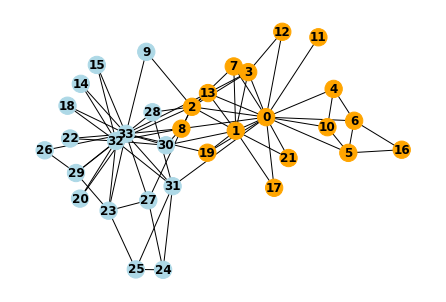

In [ ]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph() 

# each node has a class, either "Mr. Hi" or "Officer"
labels = [KCG.nodes[i]['club'] for i in KCG.nodes]
print(labels)

color_map = ['lightblue' if l == 'Officer' else 'orange' for l in labels]  

nx.draw(KCG, with_labels=True, font_weight='bold', \
        node_color=color_map)

After initializing the KarateClub dataset, we first can inspect some of its properties. This graph has 34 nodes, and 156 undirected edges. Nodes belong two classes: 'Officer' or 'Mr. Hi'. Each edge stands for communication between two nodes.

### Random Walk

Firstly, we will learn to do the node embedding. There are different embedding generation methods like node2vec, DeepWalk etc. In this example, we will use node2vec. 

Animation of random walk


<img src = 'https://miro.medium.com/max/1400/1*qKUw21HrfmQf5F8FcJgFMQ.gif' width ="70%"> </img>

(References: https://towardsdatascience.com/node2vec-explained-graphically-749e49b7eb6b)

In [ ]:
from node2vec import Node2Vec
# generate walks
node2vec = Node2Vec(KCG, dimensions=64, walk_length=10,num_walks=80)    # walk_length: How many nodes are in each random walk
#Embed nodes                                                                             # num_walks: Number of random walks to be generated from each node in the graph
node2vec_model = node2vec.fit(window=10, min_count=1,batch_words=4)                      # p: controls the probability to go back
                                                                                         # q: controls the probability to explore
# get embeddings
# The variable embeddings stores the embeddings in form of a dictionary where the keys are the nodes and values are the embeddings themselves.
embeddings_map = node2vec_model.wv
embeddings = embeddings_map[[str(i) for i in range(len(KCG.nodes))]]

embeddings.shape
#Note: any keywords acceptable by gensim.Word2vec can be passed

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 80/80 [00:01<00:00, 41.94it/s]


(34, 64)

### Biased Walk

We can set biased walking policy by adjusting parameters `p` and `q` in 'Node2Vec'

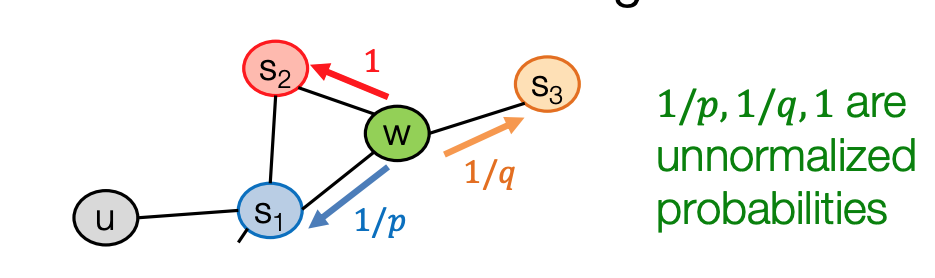


In [ ]:
# p: controls the probability to go back
# q: controls the probability to explore

Node2Vec(KCG, dimensions=64, walk_length=10,num_walks=80, workers=1,p=1,q=2)                  #smaller p: local structure
Node2Vec(KCG, dimensions=64, walk_length=10,num_walks=80, workers=1,p=2,q=1)                  #smaller q: global structure

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 80/80 [00:01<00:00, 76.97it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 80/80 [00:00<00:00, 82.43it/s]


## Visualize the embeddings
Embeddings are just low-dimensional numerical representations of the network, therefore we can make a visualization of these embeddings. Here, the size of the embeddings is 64, so we need to employ t-SNE which is a dimensionality reduction technique. Basically, t-SNE transforms the 64 dimension array into a 2-dimensional array so that we can visualize it in a 2D space. We can observe the 4groups of nodes are separated decently in the 2D space. The node embeddings are informative. 



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


([], <a list of 0 Text major ticklabel objects>)

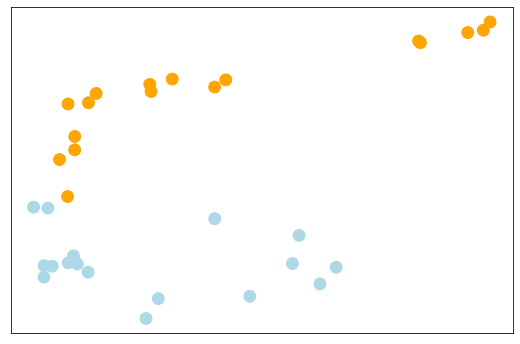

In [ ]:
#Visualize the embeddings
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# transform the embeddings from 64 dimensions to 2D space
# TSNE is a dimension deduction technique 
m = TSNE(learning_rate=20, random_state=42)
tsne_features = m.fit_transform(list(embeddings))

# retrieve the labels for each node
#labels = data.y

# plot the transformed embeddings
plt.figure(figsize=(9,6)) 
plt.scatter(x = tsne_features[:,0], 
            y = tsne_features[:,1],
            c = color_map,
            s =140,
            cmap="Set2",
            )
plt.xticks([])
plt.yticks([])


# Graph Neural Network (GNN)


References: https://towardsdatascience.com/a-beginners-guide-to-graph-neural-networks-using-pytorch-geometric-part-1-d98dc93e7742



Next, we use GNN to derive node representation and classify nodes into labels.


We divide the graph into train and test sets where we use the train set to build a graph neural network model and use the model to predict the missing node labels in the test set.


Here, we use PyTorch Geometric (PyG) python library to model the graph neural network. Alternatively, Deep Graph Library (DGL) can also be used for the same purpose.
PyTorch Geometric is a geometric deep learning library built on top of PyTorch. Several popular graph neural network methods have been implemented using PyG and you can play around with the code using built-in datasets or create your own dataset. PyG uses a nifty implementation where it provides an InMemoryDataset class which can be used to create the custom dataset (Note: InMemoryDataset should be used for datasets small enough to load in the memory).

Fist, install packages

In [ ]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-geometric 2.1.0.post1
Uninstalling torch-geometric-2.1.0.post1:
  Successfully uninstalled torch-geometric-2.1.0.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 2.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-bu

## Prepare data

The karate club dataset can be loaded directly from the NetworkX library. We retrieve the labels from the graph and create an edge index in the coordinate format. The node degree was used as embeddings/ numerical representations for the nodes (In the case of a directed graph, in-degree can be used for the same purpose). Since degree values tend to be diverse, we normalize them before using the values as input to the GNN model.


In [ ]:
import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# load graph from networkx library
G = nx.karate_club_graph()

# retrieve the labels for each node
labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# create edge index from 
adj = nx.to_scipy_sparse_matrix(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

# using degree as embedding
embeddings = np.array(list(dict(G.degree()).values()))

# normalizing degree values
scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))

## Split nodes into train/test via masking

The KarateDataset class inherits from the InMemoryDataset class and use a Data object to collate all information relating to the karate club dataset. The graph data is then split into train and test sets, thereby creating the train and test masks using the splits.

In [ ]:
import torch
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

# custom dataset
class KarateDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(KarateDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = G.number_of_nodes()
        
        # embedding 
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        
        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(list(G.nodes())), 
                                                            pd.Series(labels),
                                                            test_size=0.30, 
                                                            random_state=42)
        
        n_nodes = G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = KarateDataset()
data = dataset[0]

## Create GNN model (two-layer GNN)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN model with 2 layers 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, int(data.num_classes))

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # loss is calculated here

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data =  data.to(device)

model = Net().to(device) 

## Train model

Pay extra attention to how the loss is calculated through masking

In [ ]:
torch.manual_seed(42)

optimizer_name = "Adam"
lr = 1e-1
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
epochs = 200

def train():
  model.train()
  optimizer.zero_grad()
  F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
  optimizer.step()

@torch.no_grad()
def test():
  model.eval()
  logits = model()
  mask1 = data['train_mask']
  pred1 = logits[mask1].max(1)[1]
  acc1 = pred1.eq(data.y[mask1]).sum().item() / mask1.sum().item()
  mask = data['test_mask']
  pred = logits[mask].max(1)[1]
  acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
  return acc1,acc

for epoch in range(1, epochs):
  train()

train_acc,test_acc = test()

print('#' * 70)
print('Train Accuracy: %s' %train_acc )
print('Test Accuracy: %s' % test_acc)
print('#' * 70)

######################################################################
Train Accuracy: 0.8695652173913043
Test Accuracy: 0.7272727272727273
######################################################################


# New Section